In [29]:
!pip3 install tiktoken

In [30]:
import torch
import tiktoken

In [31]:
class Multi_Head_Attention(torch.nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout_rate, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0),"d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = torch.nn.Linear(d_in, d_out, bias=qkv_bias)

        self.Dropout = torch.nn.Dropout(dropout_rate)

        self.register_buffer("mask",torch.triu(torch.ones(context_length, context_length),diagonal=1))

    def forward(self,x):
        batch , number_of_tokens , d_in = x.shape

        self.query = self.W_query(x)
        self.key = self.W_key(x)
        self.value = self.W_value(x)

        query = self.query.view(batch,number_of_tokens,self.num_heads,self.head_dim) #Adjusting size for all heads
        key = self.key.view(batch,number_of_tokens,self.num_heads,self.head_dim)
        value = self.value.view(batch,number_of_tokens,self.num_heads,self.head_dim)

        key = key.transpose(1, 2)
        query = query.transpose(1, 2)
        value = value.transpose(1, 2)

        attention_score = query @ key.transpose(2,3)

         # Converting to true or false matrix and shaping to number of tokens
        mask_bool = self.mask.bool()[:number_of_tokens, :number_of_tokens]

        attention_score.masked_fill_(mask_bool,-torch.inf)

        attention_weights = torch.softmax(attention_score/self.head_dim**0.5,dim=-1)

        attention_weights = self.Dropout(attention_weights)

        context_vector = (attention_weights @ value).transpose(1,2)

        context_vector = context_vector.contiguous().view(batch,number_of_tokens,self.d_out)
        return context_vector

In [32]:
class Layer_normalization(torch.nn.Module):
    def __init__(self,emb_dim):
        super().__init__()
        self.epsilon = 1e-5
        self.scale = torch.nn.Parameter(torch.ones(emb_dim))
        self.shift = torch.nn.Parameter(torch.zeros(emb_dim))

    def forward(self,x):
        mean = x.mean(dim=-1,keepdim=True)
        variance = x.var(dim=-1,keepdim=True,unbiased=False)
        norm_x = (x-mean)/torch.sqrt(variance+self.epsilon)
        return self.scale*norm_x+self.shift

In [33]:
class Gelu(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x): # GELU activation function:
        # f(x) = 0.5 * x * (1 + tanh(sqrt(2/pi) * (x + 0.044715 * x^3)))
        return 0.5*x*(1+torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))*(x+0.044715*torch.pow(x,3))))

In [34]:
class Feed_forward(torch.nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(cfg["emb_dim"],4*cfg["emb_dim"]),
            Gelu(),
            torch.nn.Linear(4*cfg["emb_dim"],cfg["emb_dim"])
        )
    def forward(self,x):
        return self.layers(x)

In [35]:
class TransformerBlock(torch.nn.Module):
    def __init__(self,cfg):
        super().__init__()

        self.att = Multi_Head_Attention( d_in=cfg["emb_dim"],
                                        d_out=cfg["emb_dim"],
                                        context_length=cfg["context_length"],
                                        dropout_rate=cfg["drop_rate"],
                                        num_heads=cfg["n_heads"],
                                        qkv_bias=cfg["qkv_bias"])

        self.layer_norm1 = Layer_normalization(emb_dim=cfg["emb_dim"])

        self.layer_norm2 = Layer_normalization(emb_dim=cfg["emb_dim"])

        self.feed_forward = Feed_forward(cfg=cfg)

        self.dropout = torch.nn.Dropout(cfg["drop_rate"])

    def forward(self,x):
        shortcut =x
        x = self.layer_norm1(x)
        x = self.att(x)
        x = self.dropout(x)
        x = x+shortcut
        shortcut = x
        x = self.layer_norm2(x)
        x = self.feed_forward(x)
        x = self.dropout(x)
        x = x + shortcut
        return x


In [36]:
class GPTModel(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.tok_emb = torch.nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
        self.pos_emb = torch.nn.Embedding(cfg["context_length"],cfg["emb_dim"])
        self.drop_emb = torch.nn.Dropout(cfg["drop_rate"])
        self.transformer_blocks = torch.nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = Layer_normalization(cfg["emb_dim"])
        self.output_head = torch.nn.Linear(cfg["emb_dim"],cfg["vocab_size"],bias=False)

    def forward(self,id_idx):
        batch,seq_len = id_idx.shape
        token_embeded = self.tok_emb(id_idx)
        position_embeded = self.pos_emb(torch.arange(seq_len, device= id_idx.device))
        x = token_embeded + position_embeded
        x = self.drop_emb(x)
        x = self.transformer_blocks(x)
        x = self.final_norm(x)
        logits = self.output_head(x)
        return logits

In [37]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 1024, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}


In [38]:
model = GPTModel(GPT_CONFIG_124M)

In [39]:
class CategoricalCrossEntropy:
    def __init__(self, target):
        self.target_flat = target.flatten()

    def loss(self, logits_matrix):
        logits_flat = logits_matrix.view(-1,logits_matrix.shape[-1])
        log_probs = torch.log_softmax(logits_flat, dim=-1)
        selected_log_probs = log_probs[torch.arange(logits_flat.size(0)),self.target_flat]
        self.loss = -torch.sum(selected_log_probs) /logits_matrix.shape[0]
        return self.loss

    def perplexity(self):
        return torch.exp(self.loss)

In [40]:
with open("Fire & Blood by George R R Martin.txt", "r", encoding="utf-8") as file:
        text_data = file.read()

In [41]:
print(text_data[:20])

Fire & Blood is a 


In [42]:
print(f"Charector : {len(text_data)}")
tokenizer=tiktoken.get_encoding("gpt2")
tokens = tokenizer.encode(text_data)
print(f"Token  : {len(tokens)}")

Charector : 1444998
Token  : 379444


In [43]:
from torch.utils.data import Dataset ,DataLoader

class GPTDataset(Dataset):
    def __init__(self,text_data,tokenizer,max_length,stride):
        self.input_ids = []
        self.target_ids = []

        tokens = tokenizer.encode(text_data, allowed_special={"<|endoftext|>"})

        for i in range(0,len(tokens)-max_length,stride):

            input_chunk = tokens[i:i+max_length]
            target_chunk = tokens[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, index):
        return  self.input_ids[index],self.target_ids[index]


def dataloader_dataset(text_data, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDataset(text_data,tokenizer,max_length,stride)
    dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=shuffle,drop_last=drop_last,num_workers=num_workers)
    return dataloader

In [44]:
trian_percent = 0.8
index_train_val = int(len(text_data)*trian_percent)

train_data = text_data[:index_train_val]

val_data  = text_data[index_train_val:]
print(len(train_data),len(val_data))

train_data_loader = dataloader_dataset(train_data,batch_size=2,max_length=GPT_CONFIG_124M["context_length"],
                                          stride=GPT_CONFIG_124M["context_length"],drop_last=True,shuffle=True,num_workers=0)

val_data_loader = dataloader_dataset(val_data,batch_size=2,max_length=GPT_CONFIG_124M["context_length"],
                                          stride=GPT_CONFIG_124M["context_length"],drop_last=True,shuffle=True,num_workers=0)

1155998 289000


In [45]:
print("Train loader:")
for x, y in train_data_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_data_loader:
    print(x.shape, y.shape)

print(len(train_data_loader))
print(len(val_data_loader))

Train loader:
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 102

In [46]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#
# print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_data_loader, model, device)
    val_loss = calc_loss_loader(val_data_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.986816883087158
Validation loss: 10.987972568821263


In [48]:
device

device(type='cuda')

In [49]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]

        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [50]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    if device is not None:
        idx = idx.to(device)
    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [51]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [52]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [53]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate(model=model,idx=text_to_token_ids("Targaryen dynasty's", tokenizer),
                              max_new_tokens=15,context_size=GPT_CONFIG_124M["context_length"],top_k=25,
                                temperature=1.4)

    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [54]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [55]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)

num_epochs = 15
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_data_loader, val_data_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Targaryen dynasty's", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.640, Val loss 9.709
Ep 1 (Step 000005): Train loss 7.318, Val loss 7.465
Ep 1 (Step 000010): Train loss 7.253, Val loss 7.455
Ep 1 (Step 000015): Train loss 7.051, Val loss 7.323
Ep 1 (Step 000020): Train loss 7.011, Val loss 7.027
Ep 1 (Step 000025): Train loss 6.728, Val loss 6.840
Ep 1 (Step 000030): Train loss 6.567, Val loss 6.834
Ep 1 (Step 000035): Train loss 6.404, Val loss 6.579
Ep 1 (Step 000040): Train loss 6.382, Val loss 6.463
Ep 1 (Step 000045): Train loss 6.191, Val loss 6.513
Ep 1 (Step 000050): Train loss 6.248, Val loss 6.345
Ep 1 (Step 000055): Train loss 6.019, Val loss 6.375
Ep 1 (Step 000060): Train loss 6.030, Val loss 6.474
Ep 1 (Step 000065): Train loss 5.953, Val loss 6.293
Ep 1 (Step 000070): Train loss 5.911, Val loss 6.277
Ep 1 (Step 000075): Train loss 5.822, Val loss 6.240
Ep 1 (Step 000080): Train loss 6.016, Val loss 6.254
Ep 1 (Step 000085): Train loss 5.830, Val loss 6.105
Ep 1 (Step 000090): Train loss 5.769, Val loss

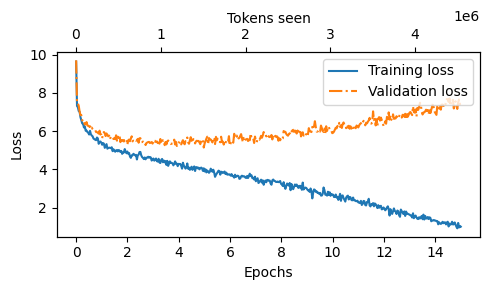

In [56]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)